In [292]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

from pathlib import Path

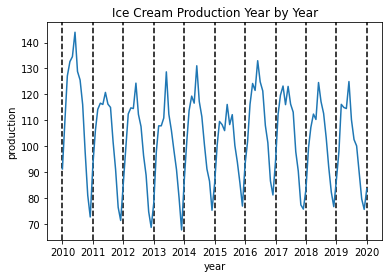

In [293]:
data = pd.read_csv(Path('data') / 'ice_cream.csv')
data.rename(columns={'DATE': 'date', 'IPN31152N': 'production'}, inplace=True)
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)
start_date = pd.to_datetime('2010-01-01')
data = data[start_date:]

plt.title('Ice Cream Production Year by Year')
plt.ylabel('production')
plt.xlabel('year')
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), 
                color='black',
                linestyle='--')
plt.plot(data.production)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

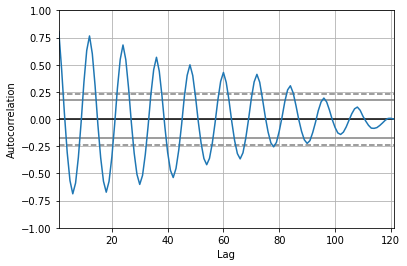

In [294]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot


# acf = plot_acf(data.production, lags=120) # 12 months * 10 years = 120 lags
autocorrelation_plot(data.production)

# Based on decaying ACF we're probably dealing with an autoregressive process 

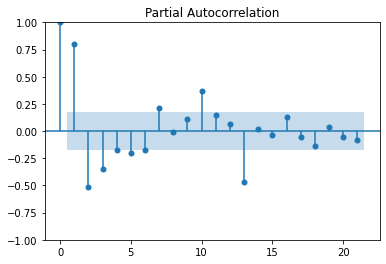

In [295]:
pacf = plot_pacf(data.production, method='ywm')

## Based on PACF we should start with an autoregressive model on lags 1, 2, 3, 10, 13

In [296]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split

# X = data.index.values
# y = data.production.values

train, test = data[:60].values, data[60:].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.1)

Coefficients: [ 7.26265493  0.9086358  -0.07295044 -0.16739223  0.2343183   0.01898743]


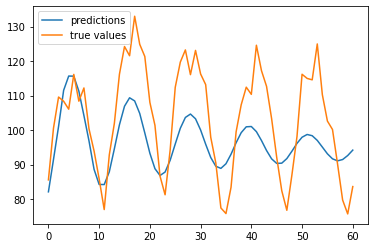

'MSE: 170.41588668164647'

In [297]:
from sklearn.metrics import mean_squared_error

model = AutoReg(train, lags=[1, 2, 3, 10, 13])
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
print('Coefficients: %s' % model_fit.params)

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()
f'MSE: {mean_squared_error(predictions, test)}'

## now let's do the same thing assuming 12-months seasonality:

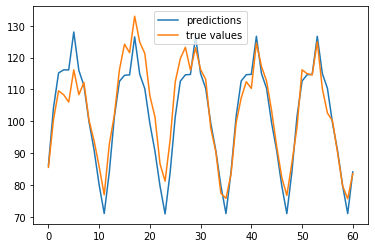

'MSE: 32.82205106561868'

In [298]:
model = AutoReg(train, lags=[1, 2, 3, 10, 13], seasonal=True, period=12)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# print('Coefficients: %s' % len(model_fit.params))

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()
f'MSE: {mean_squared_error(predictions, test)}'

In [299]:
# bingo... looks better and the MSE is way lower

### Dickey Fuller Test

In [313]:
from statsmodels.tsa.stattools import adfuller

# augmented dickey-fuller (for AR models more comlex than AR1)

adf_test_value, p_value, used_lags, nobs, _, _ = adfuller(data['production'].values)
print(f'''adf statistic: {adf_test_value} (lower than zero means no unit-roots)
p value: {p_value}''')

adf statistic: -3.469206803861127 (lower than zero means no unit-roots)
p value: 0.00881405532448749


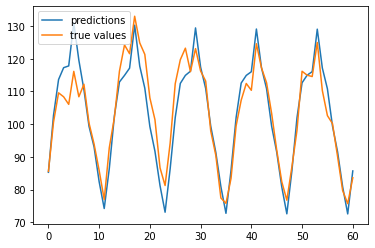

MSE: 30.722883903332164
using "number of lags" from the aug-dickey-fuller test helped!


In [314]:
# let's try to retrain the model with the number of lags produced by the augmented dickey-fuller
# test

model = AutoReg(train, lags=used_lags, seasonal=True, period=12)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# print('Coefficients: %s' % len(model_fit.params))

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()

print(f'''MSE: {mean_squared_error(predictions, test)}
using "number of lags" from the aug-dickey-fuller test helped!''')

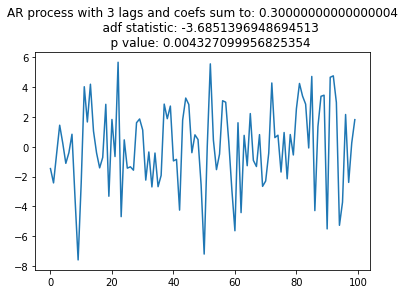

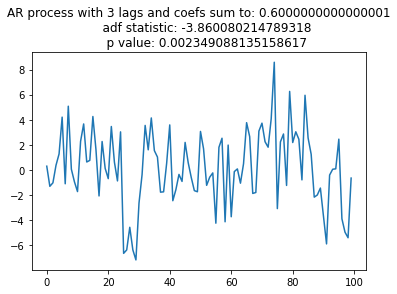

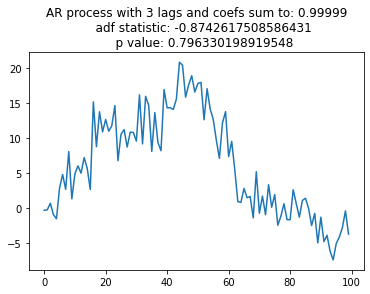

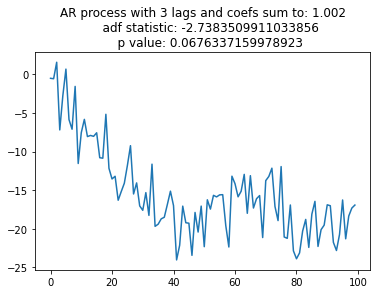

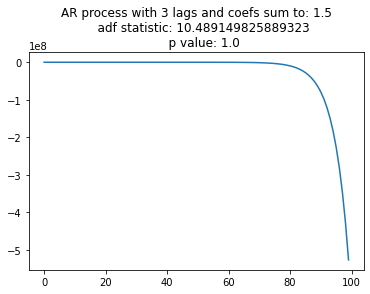

In [416]:
def generate_ar_process(lags: int, coefs: list[float], length: int) -> np.array:
    if len(coefs) != lags:
        raise ValueError(f'number of coefs ({len(coefs)}) must match lags: ({lags})')
        
    coefs = np.array(coefs)
    series = [np.random.normal() for _ in range(lags)] # generate first lags (normally distributed)
    
    for _ in range(length - lags):
        previous_values = series[-lags:][::-1] # take 'lags' values from in reversed order
        new_value = np.sum(np.array(previous_values) * coefs + np.random.normal())
        series.append(new_value)
    return np.array(series)

lags = 3
for coef in [0.1, 0.2, 0.33333, 0.334, 0.5]:
    coefs = [coef, coef, coef]
    generated_tseries = generate_ar_process(lags, coefs, 100)
    plt.title(f'''AR process with {lags} lags and coefs sum to: {sum(coefs)}
    adf statistic: {adfuller(generated_tseries)[0]}
    p value: {adfuller(generated_tseries)[1]}''')
    plt.plot(generated_tseries)
    plt.show()


### process remains stationary as long as sum of coefs is lower than 1
### when it's 1 and higher it gets a clean trend (trend-stationary?) 
### when it's significantly higher than 1 it become a smooth exponential 

# S&P500 

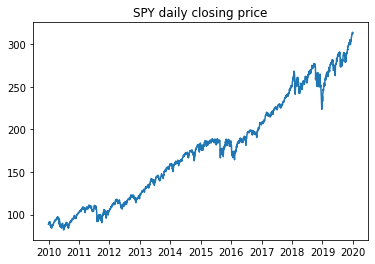

In [422]:
import yfinance 

spy_data = yfinance.Ticker('SPY')
spy_data = spy_data.history(period='1d', start='2010-01-01', end='2020-01-01')
closing_prices = spy_data[['Close']]
plt.title('SPY daily closing price')
plt.plot(closing_prices)
plt.show()

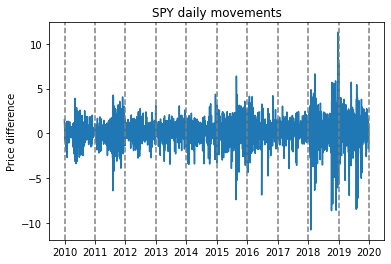

In [303]:
daily_diffs = closing_prices.values[1:] - closing_prices[:-1]
plt.title('SPY daily movements')
plt.ylabel('Price difference')
plt.plot(daily_diffs)
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle='--', color='gray')
plt.show()

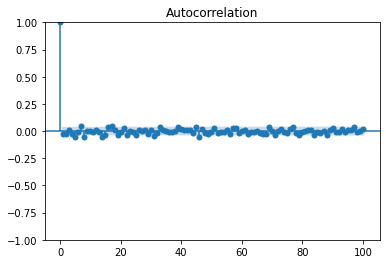

In [304]:
acf_plot = plot_acf(daily_diffs, lags=100)

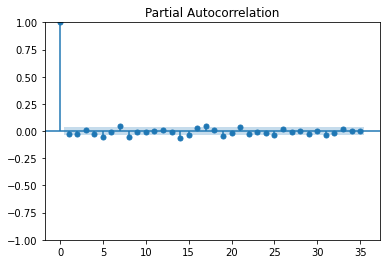

In [417]:
pacf_plot = plot_pacf(daily_diffs, method='ywm')

# no significant autocorrelation (predict stock-market movements is not easy)

In [427]:
def get_ticker_data(ticker: str, start_date: str, end_date: str, period='1d'):
    ticker_data = yfinance.Ticker(ticker)
    ticker_data = ticker_data.history(period='1d', start=start_date, end=end_date)
    return ticker_data[['Close']]

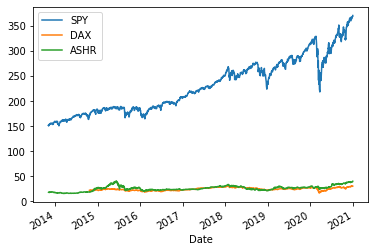

In [466]:
market_data = pd.DataFrame()
start, end = '2013-11-06','2021-01-01'
market_data['SPY'] = get_ticker_data('SPY', start_date=start, end_date=end)
market_data['DAX'] = get_ticker_data('DAX', start_date=start, end_date=end)
sse_index_tracking_fund = 'ASHR' #Xtrackers Hvst CSI 300 China A-Shs ETF
market_data[sse_index_tracking_fund] = get_ticker_data(sse_index_tracking_fund, start_date=start, end_date=end)
market_data.plot() # market_data.plot() and not plt.plot(market_data) to get labels automatically from cols
plt.legend()
plt.show()

In [469]:
market_data.corr() # correlation between markets seems between ~62% end ~66%

,SPY,DAX,ASHR
SPY,1.000000,0.656175,0.648154
DAX,0.656175,1.000000,0.624539
ASHR,0.648154,0.624539,1.000000
